# 0. Setting Up Env

## 0.1 Import Packages

In [21]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [23]:
from scipy import stats

In [24]:
from  lightgbm import LGBMRegressor,LGBMClassifier,log_evaluation,early_stopping
import xgboost

In [25]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

In [26]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index

## 0.2 Custom Functions

In [27]:
def get_feature_types(df):
    """
    Returns a dictionary containing lists of object (categorical), numerical, and boolean columns.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame

    Returns:
    dict: A dictionary with keys 'object', 'numeric', and 'boolean' containing respective column lists
    """
    type_len = {
        "object_len": len(df.select_dtypes(include=['object']).columns.tolist()),
        "int_len": len(df.select_dtypes(include=['int']).columns.tolist()),
        "float_len": len(df.select_dtypes(include=['float']).columns.tolist()),
        "boolean_len": len(df.select_dtypes(include=['bool']).columns.tolist())
    }

    feature_types = {
        "object": df.select_dtypes(include=['object']).columns.tolist(),
        "int": df.select_dtypes(include=['int']).columns.tolist(),
        "float": df.select_dtypes(include=['float']).columns.tolist(),
        "boolean": df.select_dtypes(include=['bool']).columns.tolist()
    }
    return type_len, feature_types

In [28]:
def null_summary(df):
    """
    Creates a DataFrame summarizing missing values for selected features.

    Parameters:
    df (pd.DataFrame): The input DataFrame (e.g., X_train)
    

    Returns:
    pd.DataFrame: A DataFrame with feature names, total null values, and percentage of null values.
    """
    feature_list = df.columns
    # feature_list (list): List of features to analyze
    
    null_counts = df[feature_list].isna().sum() 
    null_percent = (null_counts / len(df)) * 100 

    summary_df = pd.DataFrame({
        "Feature": feature_list,
        "Total Null Values": null_counts.values,
        "% Null Values": null_percent.values
    }).sort_values(by="% Null Values", ascending=False) 

    return summary_df

In [29]:
def plot_category_distribution(df, column_name, normalize=True):
    """
    Plots a pie chart showing the distribution of a categorical feature.

    Parameters:
    df (pd.DataFrame): The input DataFrame (e.g., X_train)
    column_name (str): The categorical column to visualize
    normalize (bool): Whether to normalize the value counts (default: True)
    """
    # Compute value counts
    vc = df[column_name].value_counts(normalize=normalize)
    print(vc)

    sns.set_style("whitegrid")
    colors = sns.color_palette("pastel", len(vc))
    plt.figure(figsize=(7, 7))
    plt.pie(vc, labels=vc.index, autopct="%.1f%%", startangle=90, colors=colors, wedgeprops={"edgecolor": "black"})

    plt.title(f"Distribution of {column_name}", fontsize=14)
    plt.show()
    plt.show()



In [30]:
# Calculate Cramér's V for each pair of categorical columns
def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    phi2 = chi2/n
    r, k = crosstab.shape
    return np.sqrt(phi2 / min(k-1, r-1))



## 0.3 Other Setups

In [31]:
pd.set_option("display.max_columns", None)  # Show all columns
pd.set_option("display.width", 1000)  # Increase display width

In [32]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
seed_everything(seed=99)

# 1. Import Data

In [33]:
data_dir = "/06 CIBMTR/01 Data" 
train=pd.read_csv("D:/01 Work/01 Coding/01 Hackathons/06 CIBMTR/01 Data/train.csv")
test=pd.read_csv("D:/01 Work/01 Coding/01 Hackathons/06 CIBMTR/01 Data/test.csv")
print(f" Train Data Shape : ", train.shape)
print(f" Test Data Shape : ", test.shape)

train.head(3)

 Train Data Shape :  (28800, 60)
 Test Data Shape :  (3, 58)


,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,hla_high_res_6,cmv_status,hla_high_res_10,hla_match_dqb1_high,tce_imm_match,hla_nmdp_6,hla_match_c_low,rituximab,hla_match_drb1_low,hla_match_dqb1_low,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,year_hct,obesity,mrd_hct,in_vivo_tcd,tce_match,hla_match_a_high,hepatic_severe,donor_age,prior_tumor,hla_match_b_low,peptic_ulcer,age_at_hct,hla_match_a_low,gvhd_proph,rheum_issue,sex_match,hla_match_b_high,race_group,comorbidity_score,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10,efs,efs_time
0,0,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,Bone marrow,No,No,No,IEA,6.0,+/+,NaN,2.0,NaN,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2016,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,9.942,2.0,FKalone,No,M-F,2.0,More than one race,0.0,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,42.356
1,1,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,Peripheral blood,No,No,No,AML,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,PB,Intermediate,MAC,Not Hispanic or Latino,2008,No,Positive,No,Permissive,2.0,No,72.29,No,2.0,No,43.705,2.0,Other GVHD Prophylaxis,No,F-F,2.0,Asian,3.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0,1.0,4.672
2,2,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,Bone marrow,No,No,No,HIS,6.0,+/+,10.0,2.0,P/P,6.0,2.0,No,2.0,2.0,BM,NaN,NaN,Not Hispanic or Latino,2019,No,NaN,Yes,NaN,2.0,No,NaN,No,2.0,No,33.997,2.0,Cyclophosphamide alone,No,F-M,2.0,More than one race,0.0,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0,0.0,19.793


In [34]:
set(train.columns) - set(test.columns)

{'efs', 'efs_time'}

# 2. EDA Data

In [35]:
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

X_train.dtypes


ID                          int64
dri_score                  object
psych_disturb              object
cyto_score                 object
diabetes                   object
hla_match_c_high          float64
hla_high_res_8            float64
tbi_status                 object
arrhythmia                 object
hla_low_res_6             float64
graft_type                 object
vent_hist                  object
renal_issue                object
pulm_severe                object
prim_disease_hct           object
hla_high_res_6            float64
cmv_status                 object
hla_high_res_10           float64
hla_match_dqb1_high       float64
tce_imm_match              object
hla_nmdp_6                float64
hla_match_c_low           float64
rituximab                  object
hla_match_drb1_low        float64
hla_match_dqb1_low        float64
prod_type                  object
cyto_score_detail          object
conditioning_intensity     object
ethnicity                  object
year_hct      

In [36]:
ft_count, ft_cat = get_feature_types(X_train)
ft_count, len(X_train.columns)

({'object_len': 35, 'int_len': 2, 'float_len': 21, 'boolean_len': 0}, 58)

# 3. Numerical Columns

## 3.1 Integer Feat.

In [37]:

print(f"Total Integer Features : ", ft_count['int_len'])
X_train[ft_cat['int']].head()

Total Integer Features :  2


,ID,year_hct
0,0,2016
1,1,2008
2,2,2019
3,3,2009
4,4,2018


In [38]:
# ID, is not needed so we can drop it
X_train.drop('ID', axis=1, inplace=True)
print(X_train.shape)

(28800, 57)


In [39]:
X_train["year_hct"].isna().sum()

np.int64(0)

In [40]:
X_train["year_hct"].describe()

count    28800.000000
mean      2015.179444
std          3.153914
min       2008.000000
25%       2013.000000
50%       2016.000000
75%       2018.000000
max       2020.000000
Name: year_hct, dtype: float64

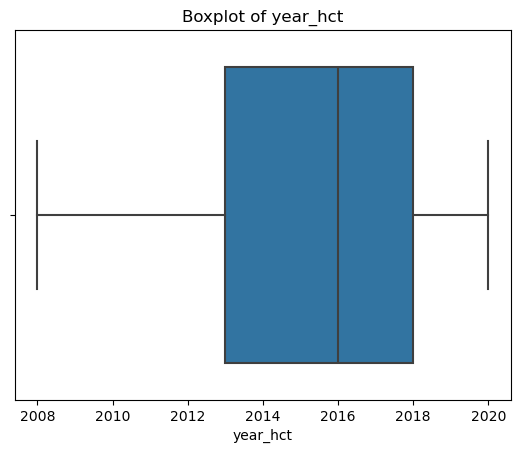

In [41]:
sns.boxplot(x=X_train["year_hct"])  

plt.title("Boxplot of year_hct")
plt.show()


## 3.2 Float Features

In [42]:
print(f"Total Float Features : ", ft_count['float_len'])
X_train[ft_cat['float']].head()

Total Float Features :  21


,hla_match_c_high,hla_high_res_8,hla_low_res_6,hla_high_res_6,hla_high_res_10,hla_match_dqb1_high,hla_nmdp_6,hla_match_c_low,hla_match_drb1_low,hla_match_dqb1_low,hla_match_a_high,donor_age,hla_match_b_low,age_at_hct,hla_match_a_low,hla_match_b_high,comorbidity_score,karnofsky_score,hla_low_res_8,hla_match_drb1_high,hla_low_res_10
0,NaN,NaN,6.0,6.0,NaN,2.0,6.0,2.0,2.0,2.0,2.0,NaN,2.0,9.942,2.0,2.0,0.0,90.0,8.0,2.0,10.0
1,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,72.29,2.0,43.705,2.0,2.0,3.0,90.0,8.0,2.0,10.0
2,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,NaN,2.0,33.997,2.0,2.0,0.0,90.0,8.0,2.0,10.0
3,2.0,8.0,6.0,6.0,10.0,2.0,6.0,2.0,2.0,2.0,2.0,29.23,2.0,43.245,2.0,2.0,0.0,90.0,8.0,2.0,10.0
4,2.0,8.0,6.0,6.0,10.0,2.0,5.0,2.0,2.0,2.0,2.0,56.81,2.0,29.740,2.0,2.0,1.0,90.0,8.0,2.0,10.0


In [43]:
int_null_summary = null_summary(X_train[ft_cat['float']])
int_null_summary

,Feature,Total Null Values,% Null Values
4,hla_high_res_10,7163,24.871528
1,hla_high_res_8,5829,20.239583
3,hla_high_res_6,5284,18.347222
5,hla_match_dqb1_high,5199,18.052083
20,hla_low_res_10,5064,17.583333
0,hla_match_c_high,4620,16.041667
10,hla_match_a_high,4301,14.934028
6,hla_nmdp_6,4197,14.572917
9,hla_match_dqb1_low,4194,14.562500
15,hla_match_b_high,4088,14.194444


# 4. Categorical Columns

In [44]:
print(f"Total Categorical Features : ", ft_count['object_len'])
X_train[ft_cat['object']].head()

Total Categorical Features :  35


,dri_score,psych_disturb,cyto_score,diabetes,tbi_status,arrhythmia,graft_type,vent_hist,renal_issue,pulm_severe,prim_disease_hct,cmv_status,tce_imm_match,rituximab,prod_type,cyto_score_detail,conditioning_intensity,ethnicity,obesity,mrd_hct,in_vivo_tcd,tce_match,hepatic_severe,prior_tumor,peptic_ulcer,gvhd_proph,rheum_issue,sex_match,race_group,hepatic_mild,tce_div_match,donor_related,melphalan_dose,cardiac,pulm_moderate
0,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,IEA,+/+,NaN,No,BM,NaN,NaN,Not Hispanic or Latino,No,NaN,Yes,NaN,No,No,No,FKalone,No,M-F,More than one race,No,NaN,Unrelated,"N/A, Mel not given",No,No
1,Intermediate,No,Intermediate,No,"TBI +- Other, >cGy",No,Peripheral blood,No,No,No,AML,+/+,P/P,No,PB,Intermediate,MAC,Not Hispanic or Latino,No,Positive,No,Permissive,No,No,No,Other GVHD Prophylaxis,No,F-F,Asian,No,Permissive mismatched,Related,"N/A, Mel not given",No,Yes
2,N/A - non-malignant indication,No,NaN,No,No TBI,No,Bone marrow,No,No,No,HIS,+/+,P/P,No,BM,NaN,NaN,Not Hispanic or Latino,No,NaN,Yes,NaN,No,No,No,Cyclophosphamide alone,No,F-M,More than one race,No,Permissive mismatched,Related,"N/A, Mel not given",No,No
3,High,No,Intermediate,No,No TBI,No,Bone marrow,No,No,No,ALL,+/+,P/P,No,BM,Intermediate,MAC,Not Hispanic or Latino,No,Positive,No,Permissive,No,No,No,FK+ MMF +- others,No,M-M,White,Yes,Permissive mismatched,Unrelated,"N/A, Mel not given",No,No
4,High,No,NaN,No,No TBI,No,Peripheral blood,No,No,No,MPN,+/+,NaN,No,PB,NaN,MAC,Hispanic or Latino,No,NaN,Yes,NaN,No,No,No,TDEPLETION +- other,No,M-F,American Indian or Alaska Native,No,Permissive mismatched,Related,MEL,No,No


In [45]:
cat_null_summary = null_summary(X_train[ft_cat['object']])
cat_null_summary

,Feature,Total Null Values,% Null Values
21,tce_match,18996,65.958333
19,mrd_hct,16597,57.628472
15,cyto_score_detail,11923,41.399306
30,tce_div_match,11396,39.569444
12,tce_imm_match,11133,38.656250
2,cyto_score,8068,28.013889
16,conditioning_intensity,4789,16.628472
33,cardiac,2542,8.826389
24,peptic_ulcer,2419,8.399306
5,arrhythmia,2202,7.645833


# END